# Phase 1: Static ASL Training & Ablations

### Imports

In [64]:
# Standard PyTorch + Torchvision stack
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score

# Reproducibility (essential for research and debugging)
import random
SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device 
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
    print('Using device: cuda')
else:
    DEVICE = torch.device('cpu')
    print('Using device: cpu')

# Loading data
import numpy as np
import kagglehub
import os
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import random
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

Using device: cuda


### ResNet-18

In [2]:
# Load ResNet-18
res18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

### Preprocessing

In [3]:
# ImageNet channel-wise statistics (computed over millions of images)
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # Mean per channel (R, G, B)
IMAGENET_STD  = [0.229, 0.224, 0.225]  # Std dev per channel

In [9]:
IMG_SIZE = 224
BATCH_SIZE = 64
SEED = 429

# Download data
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
data_dir = os.path.join(path, "asl_alphabet_train", "asl_alphabet_train")

# Training transforms
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Validation transforms
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Load dataset
raw_dataset = datasets.ImageFolder(root=data_dir)

# Indices and labels
indices = np.arange(len(raw_dataset))
labels = np.array(raw_dataset.targets)

# 80/20 Stratified Split
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=SEED
)

train_source = datasets.ImageFolder(root=data_dir, transform=train_tf)
val_source   = datasets.ImageFolder(root=data_dir, transform=val_tf)

train_ds = Subset(train_source, train_idx)
val_ds   = Subset(val_source, val_idx)

train_ds.classes = train_source.classes
val_ds.classes = val_source.classes

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

NUM_CLASSES = 29
print(f' Dataset: {len(train_ds):,} train, {len(val_ds):,} val')
print(f' Classes: {train_ds.classes}')

 Dataset: 69,600 train, 17,400 val
 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


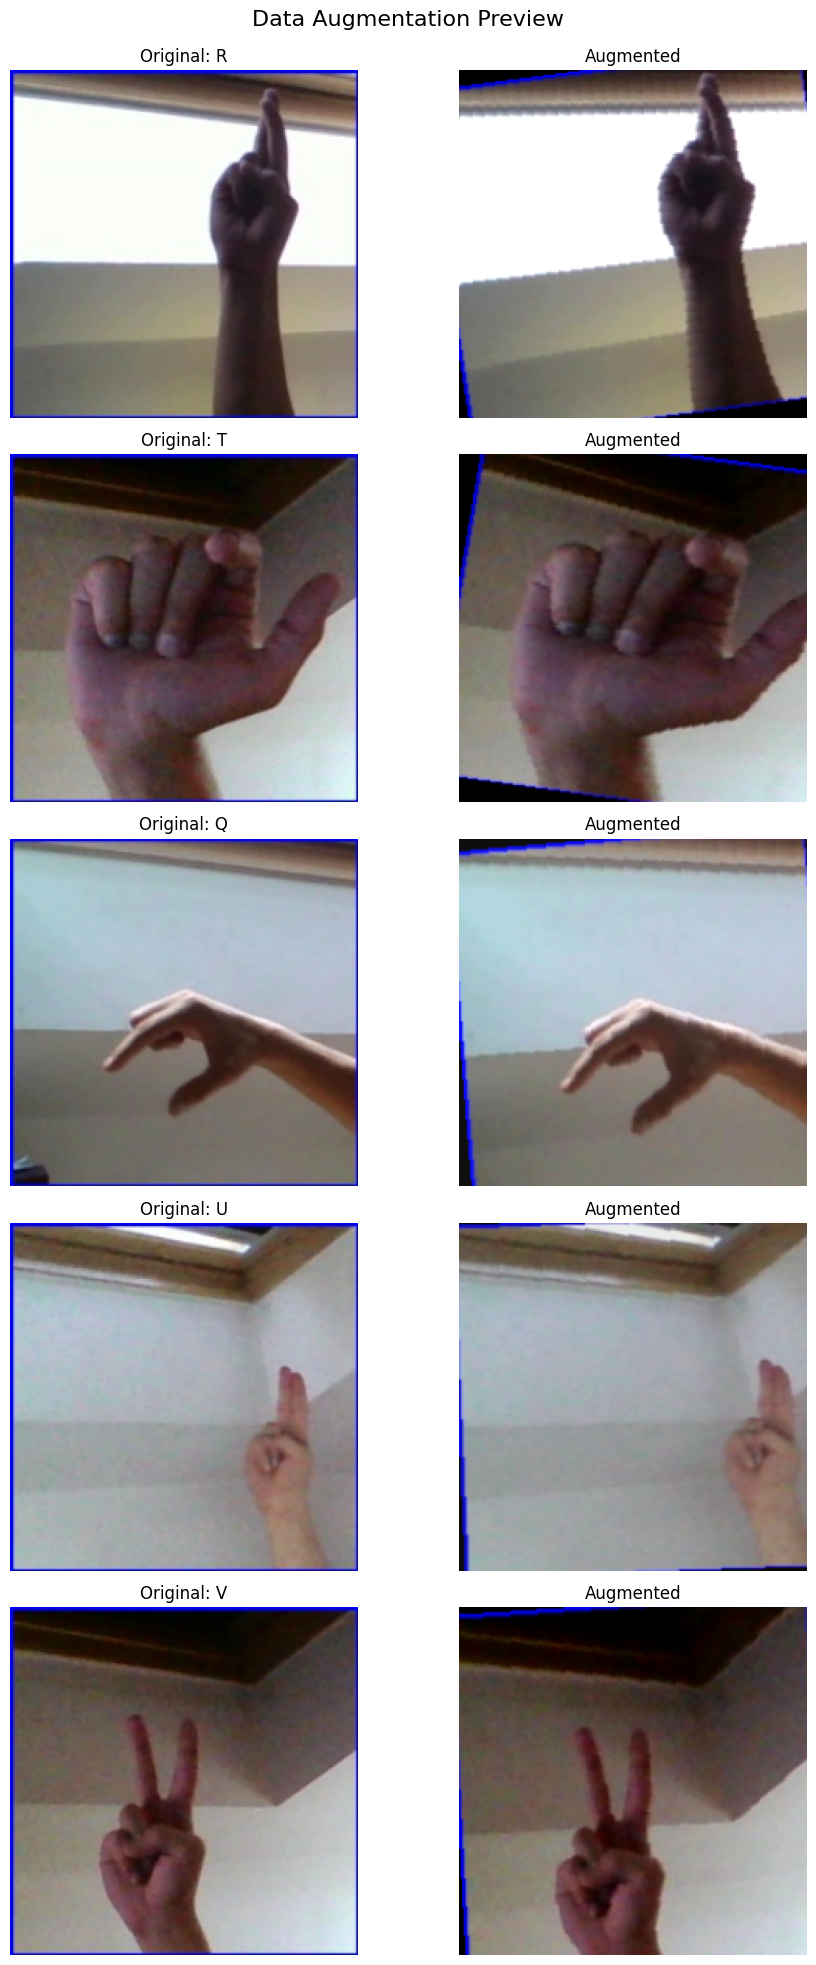

In [11]:
def visualize_augmentations(root_dir, count=5):
    vis_aug_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.85, 1.0), ratio=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor()
    ])

    vis_base_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])

    class_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    fig, axes = plt.subplots(count, 2, figsize=(10, 4 * count))
    fig.suptitle("Data Augmentation Preview", fontsize=16)

    for i in range(count):
        cls = random.choice(class_names)
        cls_path = os.path.join(root_dir, cls)
        img_name = random.choice(os.listdir(cls_path))
        img_path = os.path.join(cls_path, img_name)

        img = Image.open(img_path).convert("RGB")

        img_before = vis_base_tf(img)
        img_after = vis_aug_tf(img)

        # Convert tensors to numpy for plotting
        img_before_np = img_before.permute(1, 2, 0).numpy()
        img_after_np = img_after.permute(1, 2, 0).numpy()

        # Plot before
        axes[i, 0].imshow(img_before_np)
        axes[i, 0].set_title(f"Original: {cls}")
        axes[i, 0].axis("off")

        # Plot after
        axes[i, 1].imshow(img_after_np)
        axes[i, 1].set_title("Augmented")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Run visualization
visualize_augmentations(data_dir)

### Adapt ResNet-18 for ASL

In [12]:
# Start with ImageNet-pretrained weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Examine the original classifier
print(" Original FC layer:")
print(f"  Input features: {model.fc.in_features}")
print(f"  Output features: {model.fc.out_features} (ImageNet classes)")

# Replace with our custom classifier
# The in_features must match (512 for ResNet-18's final feature size)
# The NUM_CLASSES will change for other datasets
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

print("\n New FC layer:")
print(f"  Input features: {model.fc.in_features}")
print(f"  Output features: {model.fc.out_features} (our classes)")

# Move model to GPU if available
model = model.to(DEVICE)

 Original FC layer:
  Input features: 512
  Output features: 1000 (ImageNet classes)

 New FC layer:
  Input features: 512
  Output features: 29 (our classes)


### Freezing and Unfreezing

In [13]:
def set_requires_grad(module: nn.Module, requires_grad: bool):
    """
    Recursively set requires_grad for all parameters in a module.

    Args:
        module: PyTorch module (layer, block, or entire model)
        requires_grad: True to unfreeze (train), False to freeze
    """
    for param in module.parameters():
        param.requires_grad = requires_grad

    # Print status
    param_count = sum(p.numel() for p in module.parameters())
    status = "UNFROZEN (trainable)" if requires_grad else "FROZEN"
    print(f"  {module.__class__.__name__}: {param_count:,} parameters {status}")

### Training and Evaluation Functions

In [14]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer):
    """
    Train for one epoch.

    Returns:
        tuple: (average_loss, accuracy)
    """
    model.train()  # Enable dropout, batch norm training mode

    total_samples = 0
    correct_predictions = 0
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(loader):
        # Move data to device (GPU/CPU)
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        optimizer.zero_grad()  # Clear previous gradients
        logits = model(images)
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        # Track metrics
        running_loss += loss.item() * images.size(0)
        predictions = logits.argmax(dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += images.size(0)

        # Optional: Print progress
        if batch_idx % 100 == 0:
            print(f"    Batch {batch_idx}/{len(loader)}, "
                  f"Loss: {loss.item():.4f}")

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

### Model Training

#### Grid Search Setup

In [14]:
# --- Fixed Epochs and Grid Search Space ---
# Using 3 epochs as the fixed value based on your previous runs.
FIXED_EPOCHS = 3

GRID_SEARCH_SPACE_LR_ONLY = {
    # T-A: Phase 1.1 (Head Only)
    "T-A": {"LRs": [1e-3, 5e-4, 1e-4, 5e-5]},
    # T-B: Phase 1.2 (Layer 4 + Head)
    "T-B": {"LRs": [1e-4, 5e-5, 1e-5, 5e-6]},
    # T-C: Phase 1.3 (Layer 3 + Layer 4 + Head)
    "T-C": {"LRs": [1e-5, 5e-6, 1e-6, 5e-7]},
    # S-A: Phase 1.4 (Full Fine-Tuning)
    "S-A": {"LRs": [1e-6, 5e-7, 1e-7, 5e-8]}
}

# --- Helper Function for Macro-F1 Evaluation (Needed for Model Selection) ---
@torch.no_grad()
def evaluate_macro_f1(model, loader):
    """Evaluates model and returns Accuracy and Macro-F1 (for Grid Search)."""
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        logits = model(images)
        predictions = logits.argmax(dim=1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return accuracy, macro_f1

In [16]:
def run_grid_search_phase(
    phase_id: str,
    layers_to_unfreeze: list[str],
    lr_list: list[float],
    fixed_epochs: int,
    checkpoint_prefix: str,
    device: torch.device
):
    """
    Performs a grid search over LR only for a specific fine-tuning phase.
    The model is re-initialized for each LR test to ensure independent tuning.
    """
    print(f"\n{'='*50}\nSTARTING GRID SEARCH FOR {phase_id} (Epochs={fixed_epochs})\n{'='*50}")

    best_val_f1 = -1.0
    best_config = {}
    best_weights = None

    for LR in lr_list:
        EPOCHS = fixed_epochs
        print(f"\n--- Testing Config: LR={LR} ---")

        # --- 1. Reset Model State ---
        # Starts with a fresh ImageNet-pretrained ResNet-18
        current_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        current_model.fc = nn.Linear(current_model.fc.in_features, NUM_CLASSES)
        current_model = current_model.to(device)


        # --- 2. Apply Freezing/Unfreezing ---
        set_requires_grad(current_model, False) # Freeze all first

        for layer_name in layers_to_unfreeze:
            # CORRECT FIX: Access the layer by name on the current_model object
            layer_module = getattr(current_model, layer_name)
            set_requires_grad(layer_module, True)

        # --- 3. Optimizer Setup ---
        trainable_params = filter(lambda p: p.requires_grad, current_model.parameters())
        optimizer = optim.Adam(trainable_params, lr=LR)

        # --- 4. Training Loop ---
        for epoch in range(1, EPOCHS + 1):
            print(f"  Epoch {epoch}/{EPOCHS}")

            # This calls your train_one_epoch function with detailed batch output
            train_loss, _ = train_one_epoch(current_model, train_loader, optimizer)

            val_acc, val_f1 = evaluate_macro_f1(current_model, val_loader)

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_config = {"LR": LR, "Epochs_Achieved": epoch, "Phase": phase_id}
                best_weights = current_model.state_dict()

                checkpoint_path = f"/content/drive/MyDrive/Colab Notebooks/Sign Language Recognition/{checkpoint_prefix}_best.pth"
                torch.save(best_weights, checkpoint_path)
                print(f"    ⭐ NEW BEST F1 ({best_val_f1:.4f}) SAVED to {checkpoint_path}!")

            print(f"  Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.3f} | Val F1: {val_f1:.3f}")

        print(f"Config LR={LR} finished training over {fixed_epochs} epochs.")

    print(f"\nGRID SEARCH FOR {phase_id} COMPLETE.")
    print(f"Optimal Config: {best_config}")
    print(f"Optimal Macro-F1: {best_val_f1:.4f}")
    return best_weights, best_val_f1

#### Execution Block

In [11]:
# --- EXECUTION BLOCK: Run Grid Search for All 4 Models ---

# Store the overall best results for the final comparison
final_model_f1_scores = {}

print("--- STARTING HYPERPARAMETER GRID SEARCH FOR ALL 4 MODELS ---")

# A. T-A: Phase 1.1 (Head-Only)
lr_ta = GRID_SEARCH_SPACE_LR_ONLY["T-A"]["LRs"]
best_weights_ta, best_f1_ta = run_grid_search_phase(
    "T-A", ['fc'], lr_ta, FIXED_EPOCHS, "TA_HeadOnly", DEVICE
)
final_model_f1_scores["T-A"] = best_f1_ta


# B. T-B: Phase 1.2 (Layer 4 + Head)
lr_tb = GRID_SEARCH_SPACE_LR_ONLY["T-B"]["LRs"]
best_weights_tb, best_f1_tb = run_grid_search_phase(
    "T-B", ['layer4', 'fc'], lr_tb, FIXED_EPOCHS, "TB_L4Head", DEVICE
)
final_model_f1_scores["T-B"] = best_f1_tb


# C. T-C: Phase 1.3 (Layer 3 + Layer 4 + Head)
lr_tc = GRID_SEARCH_SPACE_LR_ONLY["T-C"]["LRs"]
best_weights_tc, best_f1_tc = run_grid_search_phase(
    "T-C", ['layer3', 'layer4', 'fc'], lr_tc, FIXED_EPOCHS, "TC_L34Head", DEVICE
)
final_model_f1_scores["T-C"] = best_f1_tc


# D. S-A: Phase 1.4 (Full Fine-Tuning)
layers_SA = ['layer1', 'layer2', 'layer3', 'layer4', 'fc']
lr_sa = GRID_SEARCH_SPACE_LR_ONLY["S-A"]["LRs"]
best_weights_sa, best_f1_sa = run_grid_search_phase(
    "S-A", layers_SA, lr_sa, FIXED_EPOCHS, "SA_FullFT", DEVICE
)
final_model_f1_scores["S-A"] = best_f1_sa


print("\n" + "="*50)
print("FINAL MODEL SELECTION CANDIDATES (Validation Macro-F1):")
print(final_model_f1_scores)
print("="*50)

--- STARTING HYPERPARAMETER GRID SEARCH FOR ALL 4 MODELS ---

STARTING GRID SEARCH FOR T-A (Epochs=3)

--- Testing Config: LR=0.001 ---
  ResNet: 11,191,389 parameters FROZEN
  Linear: 14,877 parameters UNFROZEN (trainable)
  Epoch 1/3
    Batch 0/1088, Loss: 3.6112
    Batch 100/1088, Loss: 1.8954
    Batch 200/1088, Loss: 1.1709
    Batch 300/1088, Loss: 0.8767
    Batch 400/1088, Loss: 0.7740
    Batch 500/1088, Loss: 0.6606
    Batch 600/1088, Loss: 0.4503
    Batch 700/1088, Loss: 0.5518
    Batch 800/1088, Loss: 0.4515
    Batch 900/1088, Loss: 0.4403
    Batch 1000/1088, Loss: 0.3009
    ⭐ NEW BEST F1 (0.9326) SAVED to /content/drive/MyDrive/Colab Notebooks/Sign Language Recognition/TA_HeadOnly_best.pth!
  Train Loss: 0.8401 | Val Acc: 0.932 | Val F1: 0.933
  Epoch 2/3
    Batch 0/1088, Loss: 0.3612
    Batch 100/1088, Loss: 0.4979
    Batch 200/1088, Loss: 0.2827
    Batch 300/1088, Loss: 0.4087
    Batch 400/1088, Loss: 0.2710
    Batch 500/1088, Loss: 0.2409
    Batch 600/108

### Evaluation

In [13]:
# Evaluation Imports
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [17]:
@torch.no_grad()
def evaluate_full_metrics(model, loader, phase_name, class_names):
    """
    Evaluates model and returns Accuracy, Macro-F1, and Confusion Matrix components.
    """
    model.eval()

    all_preds = []
    all_labels = []

    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logits = model(images)
        predictions = logits.argmax(dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Metrics
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    # Confusion Matrix
    EXPECTED_LABELS = list(range(len(class_names)))
    cm = confusion_matrix(all_labels, all_preds, labels=EXPECTED_LABELS)

    print(f"\n--- Results for {phase_name} ---")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Macro-F1: {macro_f1:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {phase_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, macro_f1

--- 1. MODEL SELECTION: VALIDATION MACRO-F1 ---

--- Results for Validation Set (T-A (Head Only)) ---
  Accuracy: 0.9667
  Macro-F1: 0.9667


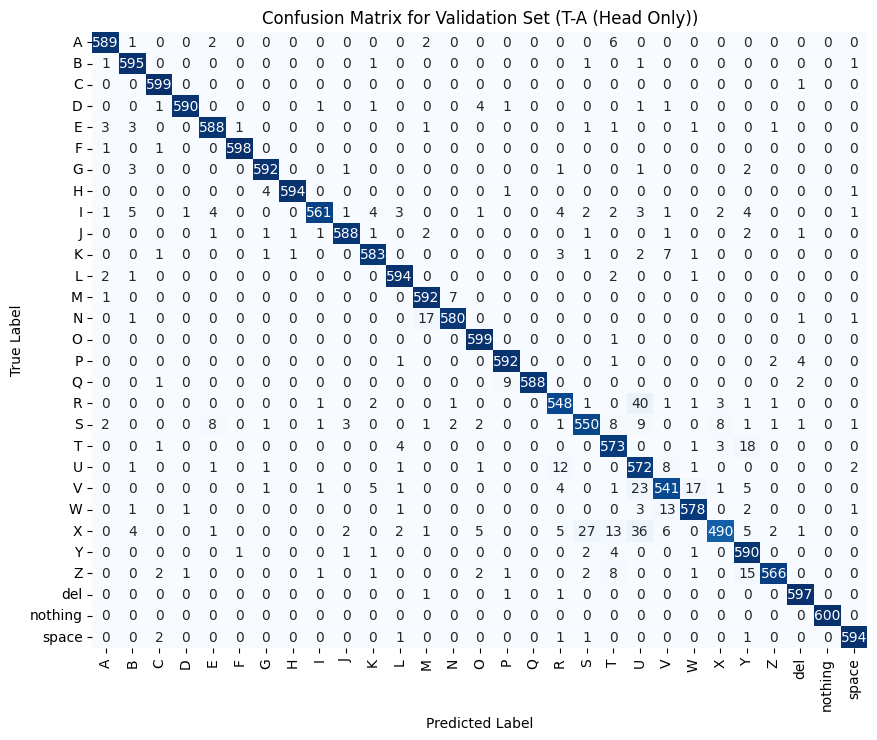


--- Results for Validation Set (T-B (L4+Head)) ---
  Accuracy: 0.9999
  Macro-F1: 0.9999


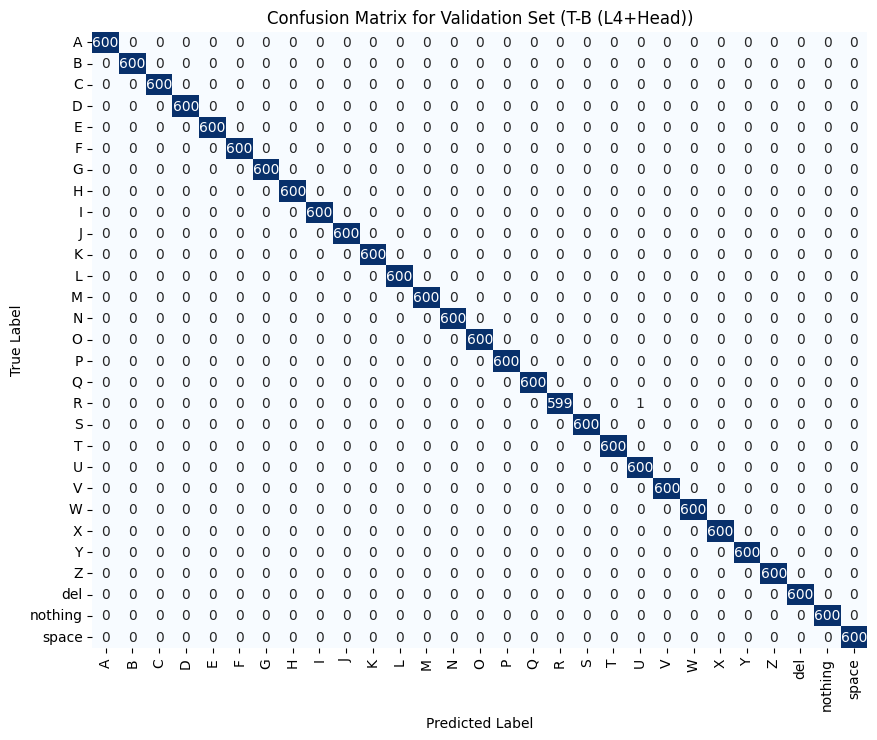


--- Results for Validation Set (T-C (L3+L4+Head)) ---
  Accuracy: 0.9999
  Macro-F1: 0.9999


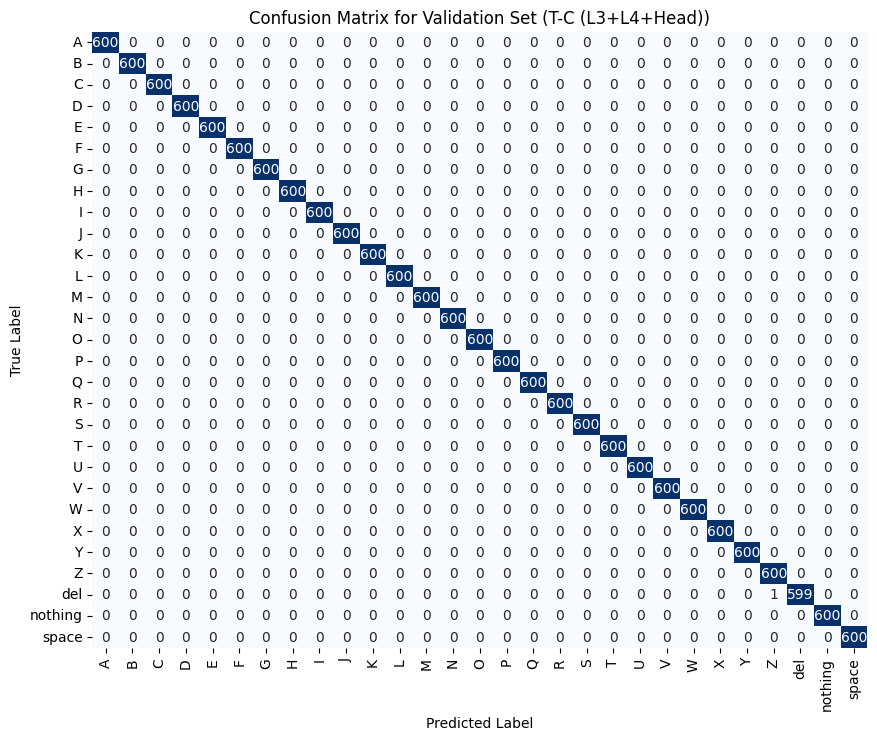


--- Results for Validation Set (S-A (Full FT)) ---
  Accuracy: 0.9823
  Macro-F1: 0.9823


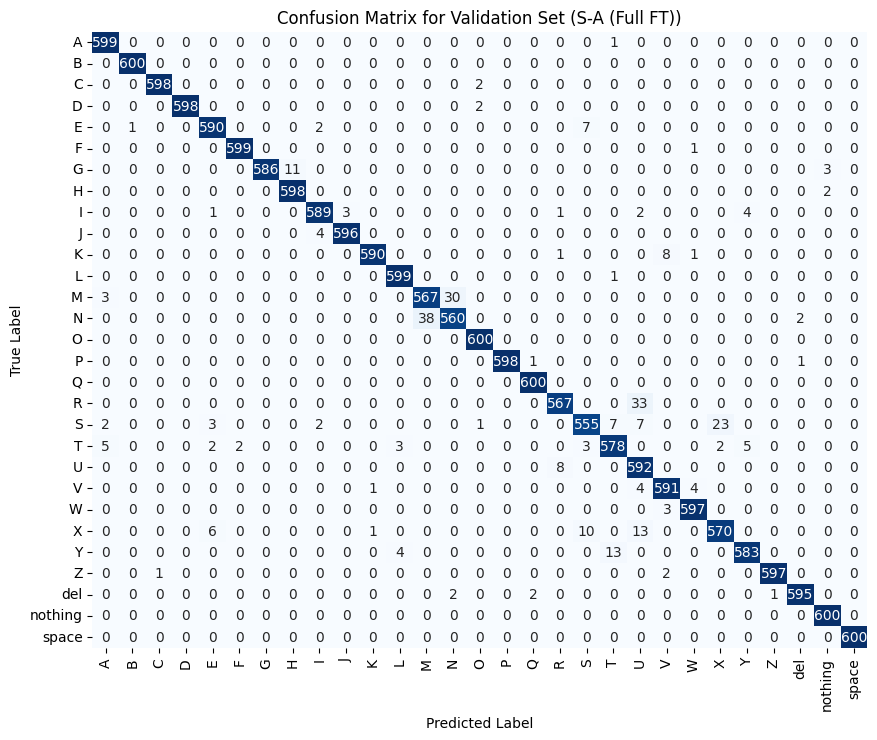


Model Selection Complete:
The best model based on Validation Macro-F1 is: **T-B (L4+Head)**
Best Macro-F1: 0.9999


In [20]:
CHECKPOINT_DIR = 'checkpoints'

MODEL_CHECKPOINTS = {
    "T-A (Head Only)": os.path.join(CHECKPOINT_DIR, 'TA_HeadOnly_best.pth'),
    "T-B (L4+Head)": os.path.join(CHECKPOINT_DIR, 'TB_L4Head_best.pth'),
    "T-C (L3+L4+Head)": os.path.join(CHECKPOINT_DIR, 'TC_L34Head_best.pth'),
    "S-A (Full FT)": os.path.join(CHECKPOINT_DIR, 'SA_FullFT_best.pth'),
}

best_overall_f1 = -1.0
best_model_id = None
best_checkpoint_path = None
results = {}

print("--- 1. MODEL SELECTION: VALIDATION MACRO-F1 ---")
for model_id, path in MODEL_CHECKPOINTS.items():
    if not os.path.exists(path):
        print(f"Skipping {model_id}: Checkpoint not found at {path}")
        continue

    # Load model weights
    model.load_state_dict(torch.load(path))

    # Evaluate on Validation Set
    val_acc, val_f1 = evaluate_full_metrics(
        model,
        val_loader,
        f"Validation Set ({model_id})",
        val_ds.classes
    )

    results[model_id] = {'Accuracy': val_acc, 'Macro-F1': val_f1}

    if val_f1 > best_overall_f1:
        best_overall_f1 = val_f1
        best_model_id = model_id
        best_checkpoint_path = path

print("\n" + "="*50)
print(f"Model Selection Complete:")
print(f"The best model based on Validation Macro-F1 is: **{best_model_id}**")
print(f"Best Macro-F1: {best_overall_f1:.4f}")
print("="*50)

### 28 Image Kaggle Test Set

In [ ]:
# Imports
from torch.utils.data import Dataset
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report

#### Load test set

In [ ]:
# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 29
IMG_SIZE = 224
BATCH_SIZE = 32

# Standard ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Prepare dataset
dataset_path = kagglehub.dataset_download("grassknoted/asl-alphabet")
test_dir = os.path.join(dataset_path, "asl_alphabet_test", "asl_alphabet_test")

class KaggleASLTestDataset(Dataset):
    # Custom dataset
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.image_paths = []
        self.labels = []
        
        if os.path.exists(root_dir):
            files = sorted(os.listdir(root_dir))
            for filename in files:
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    # Extract class: "A_test.jpg" -> "A"
                    class_name = filename.split('_')[0]
                    if class_name in self.class_to_idx:
                        self.image_paths.append(os.path.join(root_dir, filename))
                        self.labels.append(self.class_to_idx[class_name])
        else:
            print(f"Error: Path {root_dir} does not exist.")

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = Image.open(path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define Transforms
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Use mapping
try:
    class_mapping = raw_dataset.class_to_idx
except NameError:
    # Fallback if raw_dataset is not in memory
    print("Warning: raw_dataset not found. Attempting to infer classes...")
    train_dir = os.path.join(dataset_path, "asl_alphabet_train", "asl_alphabet_train")
    temp_ds = datasets.ImageFolder(train_dir)
    class_mapping = temp_ds.class_to_idx

test_ds = KaggleASLTestDataset(test_dir, class_mapping, test_transform)

# Dataloader
test_loader = DataLoader(
    test_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

# Load best model
print(f"Loading model from: {best_checkpoint_path}")

# Initialize Architecture
model = models.resnet18(weights=None) 
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

# Load State Dict
checkpoint = torch.load(best_checkpoint_path, map_location=DEVICE)
model.load_state_dict(checkpoint)
model.to(DEVICE)
model.eval()

# Run inference
print("\n--- Running Inference on 28 Kaggle Test Images ---")
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nFinal Test Accuracy: {accuracy:.4f} ({int(accuracy * len(test_ds))}/{len(test_ds)} correct)")

# Get class names from  mapping
class_names = list(class_mapping.keys())

# Create a list of all possible index numbers
all_indices = list(range(len(class_names)))

print("\nDetailed Report:")
print(classification_report(
    all_labels, 
    all_preds, 
    labels=all_indices,    
    target_names=class_names, 
    zero_division=0
))

Loading model from: checkpoints/TB_L4Head_best.pth

--- Running Inference on 28 Kaggle Test Images ---

Final Test Accuracy: 1.0000 (28/28 correct)

Detailed Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00

### Custom Test Set

In [ ]:
# Config
CUSTOM_DATA_DIR = "./asl_alphabet_custom"  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 29
BATCH_SIZE = 32

# Standard ImageNet stats
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

cuda


In [65]:
# Class mapping
class_mapping = raw_dataset.class_to_idx

# Define Custom Dataset
class LocalCustomDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.image_paths = []
        self.labels = []
        
        if os.path.exists(root_dir):
            files = sorted(os.listdir(root_dir))
            for filename in files:
                class_name = os.path.splitext(filename)[0]
                
                if class_name in self.class_to_idx:
                    self.image_paths.append(os.path.join(root_dir, filename))
                    self.labels.append(self.class_to_idx[class_name])
                else:
                    print(f"Skipping {filename}: Class '{class_name}' not in model's classes.")
        else:
            print(f"ERROR: Directory '{root_dir}' not found.")

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = Image.open(path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
val_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Create Dataset & Loader
custom_ds = LocalCustomDataset(CUSTOM_DATA_DIR, class_mapping, val_transform)

custom_loader = DataLoader(
    custom_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Loaded {len(custom_ds)} images from {CUSTOM_DATA_DIR}")

# Load Model
if 'best_checkpoint_path' not in locals():
    best_checkpoint_path = 'checkpoints/SA_FullFT_best.pth' 

print(f"Loading model from: {best_checkpoint_path}")
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(best_checkpoint_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Run Inference
all_preds = []
all_labels = []

print("\n--- Predictions ---")
with torch.no_grad():
    for images, labels in custom_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Report
idx_to_class = {v: k for k, v in class_mapping.items()}

# Print individual predictions
for i, (true_idx, pred_idx) in enumerate(zip(all_labels, all_preds)):
    true_name = idx_to_class[true_idx]
    pred_name = idx_to_class[pred_idx]
    match = "✓" if true_idx == pred_idx else "✗"
    print(f"Image {i+1}: True={true_name} | Pred={pred_name} [{match}]")

# Final Report
class_names = list(class_mapping.keys())
all_indices = list(range(len(class_names)))

print("\n--- Detailed Classification Report ---")
print(classification_report(
    all_labels, 
    all_preds, 
    labels=all_indices,       # Forces all 29 classes to appear
    target_names=class_names, 
    zero_division=0
))

Loaded 21 images from ./asl_alphabet_custom
Loading model from: checkpoints/TB_L4Head_best.pth

--- Predictions ---
Image 1: True=A | Pred=A [✓]
Image 2: True=B | Pred=B [✓]
Image 3: True=C | Pred=C [✓]
Image 4: True=D | Pred=D [✓]
Image 5: True=E | Pred=E [✓]
Image 6: True=F | Pred=F [✓]
Image 7: True=G | Pred=G [✓]
Image 8: True=H | Pred=H [✓]
Image 9: True=K | Pred=W [✗]
Image 10: True=L | Pred=Y [✗]
Image 11: True=N | Pred=N [✓]
Image 12: True=O | Pred=C [✗]
Image 13: True=P | Pred=P [✓]
Image 14: True=Q | Pred=Q [✓]
Image 15: True=R | Pred=Z [✗]
Image 16: True=S | Pred=S [✓]
Image 17: True=T | Pred=T [✓]
Image 18: True=U | Pred=E [✗]
Image 19: True=V | Pred=I [✗]
Image 20: True=W | Pred=W [✓]
Image 21: True=Z | Pred=Z [✓]

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       0.50      1.00      0.67         1
      

### Validation Error Curves

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hard coded training histories for best models
# Data extracted from your Grid Search output for the optimal LR config in each phase
# Hard coded directly from terminal output logs
# Forgot to save these during training, so recreating from logs :(
BEST_MODEL_HISTORIES = {
    "T-A (Head Only)": { # Optimal LR=0.001
        "train_loss": [0.8401, 0.2739, 0.1848],
        "val_f1": [0.933, 0.958, 0.967],
        "optimal_config": "LR=0.001"
    },
    "T-B (L4 + Head)": { # Optimal LR=5e-05
        "train_loss": [0.2496, 0.0056, 0.0018],
        "val_f1": [1.000, 1.000, 1.000],
        "optimal_config": "LR=5e-05"
    },
    "T-C (L3 + L4 + Head)": { # Optimal LR=1e-05
        "train_loss": [0.7290, 0.0376, 0.0118],
        "val_f1": [0.998, 1.000, 1.000],
        "optimal_config": "LR=1e-05"
    },
    "S-A (Full FT)": { # Optimal LR=1e-06
        "train_loss": [2.8538, 1.5777, 0.7978],
        "val_f1": [0.667, 0.939, 0.982],
        "optimal_config": "LR=1e-06"
    }
}

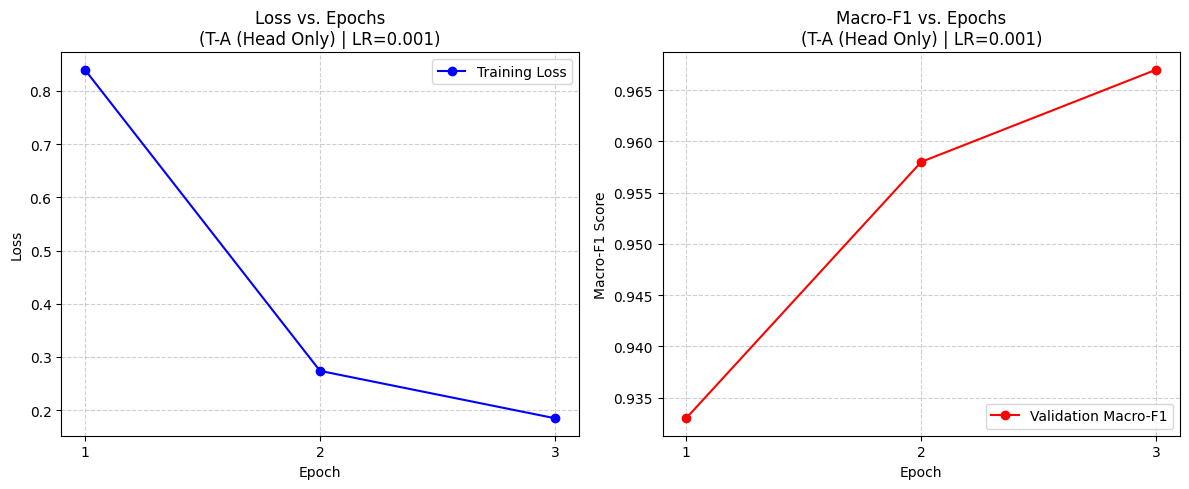

History plot saved as T-A_history.png


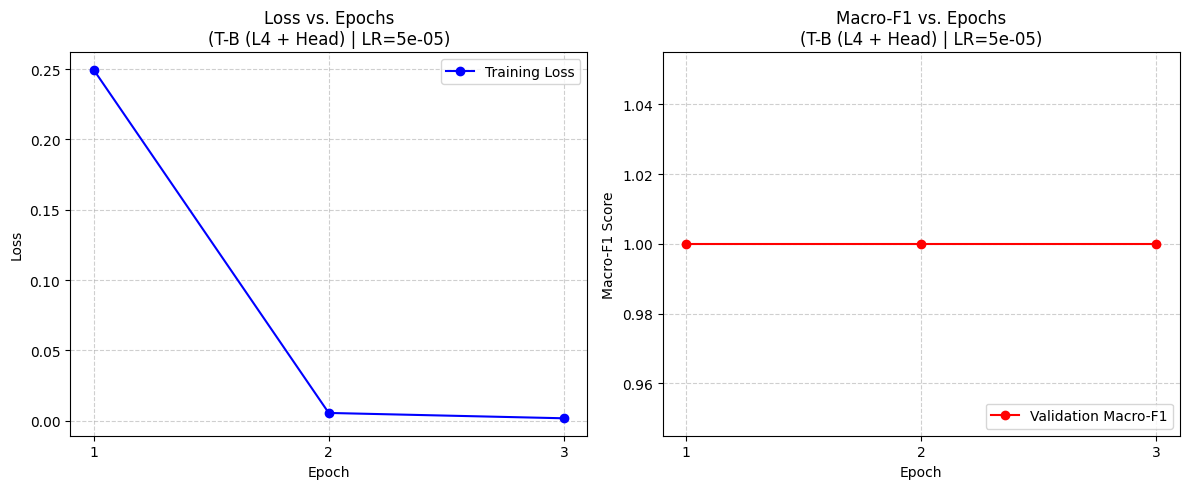

History plot saved as T-B_history.png


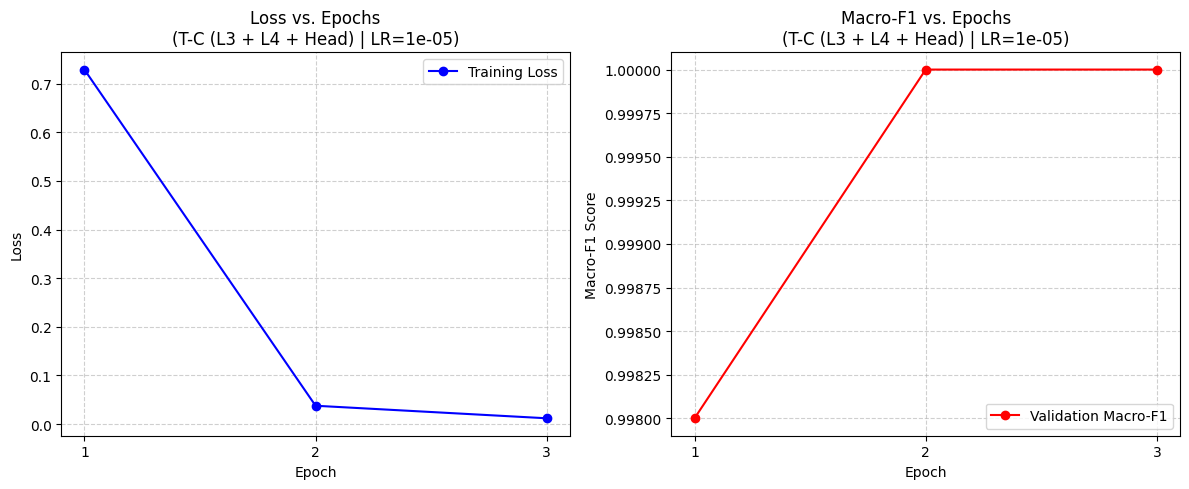

History plot saved as T-C_history.png


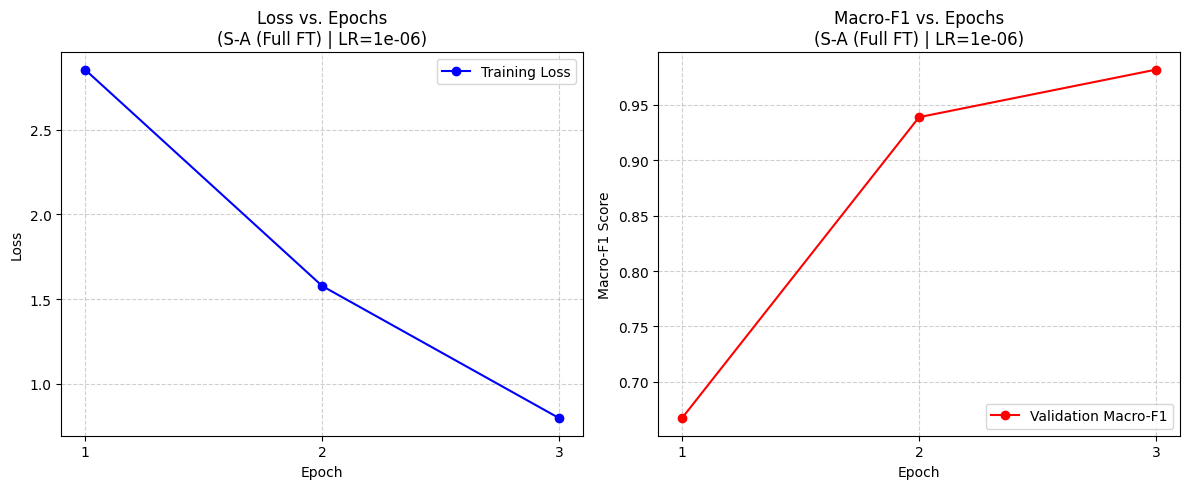

History plot saved as S-A_history.png


In [2]:
def plot_history_from_hardcode(history, model_id):
    """Plots the training loss and validation F1 score over epochs."""
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Use the optimal config string for the title
    config = history['optimal_config']
    
    # --- Plot 1: Training Loss ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.title(f'Loss vs. Epochs\n({model_id} | {config})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs) # Ensure ticks show every epoch
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # --- Plot 2: Validation F1 Score ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_f1'], 'r-o', label='Validation Macro-F1')
    plt.title(f'Macro-F1 vs. Epochs\n({model_id} | {config})')
    plt.xlabel('Epoch')
    plt.ylabel('Macro-F1 Score')
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower right')
    
    plot_filename = f"{model_id.split(' ')[0]}_history.png"
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.show() 
    print(f"History plot saved as {plot_filename}")

# --- Execution ---
for model_id, history_data in BEST_MODEL_HISTORIES.items():
    plot_history_from_hardcode(history_data, model_id)